<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [100]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [101]:
pwd

'/Users/josephbell/Desktop/DS-Unit-4-Sprint-1-NLP/module2-vector-representations'

In [110]:
df = pd.read_csv('./data/job_listings.csv')
print(df.shape)
df.head()

(426, 3)


,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [111]:
df['description'].dtype

dtype('O')

In [115]:
from bs4 import BeautifulSoup
import requests

# Clean the text
def clean_text(text):
    text = text.replace('\n', ' ')                # remove newline
    text = BeautifulSoup(text, 'html.parser').get_text() # remove html
    text = text.replace('/', ' ')                 # remove forward slashes
    text = re.sub(r'[^a-zA-Z ^0-9]', '', text)    # letters and numbers only
    text = text.lower()                           # lower case
    text = re.sub(r'(x.[0-9])', '', text)         # remove special characters
    return text

df['description'] = df.apply(lambda x: clean_text(x['description']), axis=1)

In [117]:
df.head()

,Unnamed: 0,description,title
0,0,bjob requirementsnconceptual understanding in ...,Data scientist
1,1,bjob descriptionnnas a data scientist 1 you wi...,Data Scientist I
2,2,bas a data scientist you will be working on co...,Data Scientist - Entry Level
3,3,b4969 6756 a monthcontractunder the general s...,Data Scientist
4,4,blocation usa multiple locationsn2 years of a...,Data Scientist


## 2) Use Spacy to tokenize the listings 

In [146]:
# Tech terms list
tech_terms = ['python', 'r', 'sql', 'hadoop', 'spark', 'java', 'sas', 'tableau',
              'hive', 'scala', 'aws', 'c', 'c++', 'matlab', 'tensorflow', 'excel',
              'nosql', 'linux', 'azure', 'scikit', 'machine learning', 'statistic',
              'analysis', 'computer science', 'visual', 'ai', 'deep learning',
              'nlp', 'natural language processing', 'neural network', 'mathematic',
              'database', 'oop', 'blockchain',
              'html', 'css', 'javascript', 'jquery', 'git', 'photoshop', 'illustrator',
              'word press', 'seo', 'responsive design', 'php', 'mobile', 'design', 'react',
              'security', 'ruby', 'fireworks', 'json', 'node', 'express', 'redux', 'ajax',
              'java', 'api', 'state management',
              'wireframe', 'ui prototype', 'ux writing', 'interactive design',
              'metric', 'analytic', 'ux research', 'empathy', 'collaborate', 'mockup', 
              'prototype', 'test', 'ideate', 'usability', 'high-fidelity design',
              'framework',
              'swift', 'xcode', 'spatial reasoning', 'human interface', 'core data',
              'grand central', 'network', 'objective-c', 'foundation', 'uikit', 
              'cocoatouch', 'spritekit', 'scenekit', 'opengl', 'metal', 'api', 'iot',
              'karma']

data_terms = ['data', 'science', 'scientist', 'insights', 'analytics', 'analysis', 
              'machine']

In [147]:
from spacy.tokenizer import Tokenizer
# Initialize the tokenizer
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)
STOP_WORDS = nlp.Defaults.stop_words.union(tech_terms, data_terms)
# Tokenizer pipe removing stop words and blank words and lemmatizing

In [148]:
# Tokenizer pipe removing stop words and blank words and lemmatizing
tokens = []

for doc in tokenizer.pipe(df['description'], batch_size=500):
    
    doc_tokens = []
    for token in doc:
        if (token.lemma_ not in STOP_WORDS) & (token.text != ' '):
            doc_tokens.append(token.lemma_)

    tokens.append(doc_tokens)

df['tokens'] = tokens

In [149]:
df.head()

,Unnamed: 0,description,title,tokens
0,0,bjob requirementsnconceptual understanding in ...,Data scientist,"[bjob, requirementsnconceptual, understand, le..."
1,1,bjob descriptionnnas a data scientist 1 you wi...,Data Scientist I,"[bjob, descriptionnnas, datum, 1, help, build,..."
2,2,bas a data scientist you will be working on co...,Data Scientist - Entry Level,"[bas, datum, work, consult, business, responsi..."
3,3,b4969 6756 a monthcontractunder the general s...,Data Scientist,"[b4969, 6756, monthcontractunder, general, sup..."
4,4,blocation usa multiple locationsn2 years of a...,Data Scientist,"[blocation, usa, multiple, locationsn2, year, ..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [167]:
# Apply CountVectorizer to our Data
# Use custom Spacy Vectorizer
# BBC articles in `data` variable

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

vect = CountVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(tech_terms, data_terms))

#Learn our Vocab
vect.fit(df['description'])

# Get sparse dtm
dtm = vect.transform(df['description'])

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

/Users/josephbell/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['central', 'computer', 'core', 'deep', 'fidelity', 'grand', 'high', 'human', 'interactive', 'interface', 'language', 'learning', 'management', 'natural', 'neural', 'objective', 'press', 'processing', 'reasoning', 'research', 'responsive', 'spatial', 'state', 'ui', 'ux', 'word', 'writing'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [168]:
dtm.head()

,02,02115njob,03,030nnmicrosoft,04,06366,08,10,100,1000,...,zeus,zf,zfs,zheng,zillow,zillows,zonesnability,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [173]:
top_words = dtm.sum().sort_values(ascending=False)[:15]
top_words

business       1111
experience     1031
work            932
team            859
learning        857
statistical     565
product         554
models          530
new             526
skills          454
solutions       435
years           432
help            432
using           419
working         395
dtype: int64

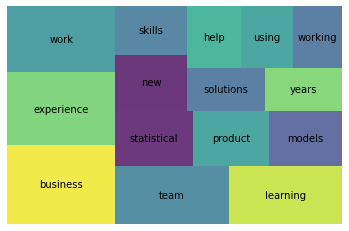

In [174]:
import squarify
import matplotlib.pyplot as plt

squarify.plot(sizes=top_words, label=top_words.index, alpha=.8 )
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [175]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english')

# Create a vocabulary and get word counts per document
# Similiar to fit_predict
dtm = tfidf.fit_transform(df['description'])

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,02,02115njob,03,030nnmicrosoft,04,06366,08,10,100,1000,...,zeus,zf,zfs,zheng,zillow,zillows,zonesnability,zoom,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.103678,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [177]:
def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [179]:
# Tunning Parameters

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', 
                       tokenizer=tokenize, 
                       min_df=2, 
                       max_df=.95,
                       max_features=5000,
                       ngram_range=(1,2)
                       )

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(df['description'])

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,,ability,able,analytic,big,business,datum,deep,disability,engineer,...,year relevant,year work,yes,york,york city,young,younnabout,younnwe,yrs,zf
0,0.044144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.042668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.055515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.103009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [191]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [200]:
dream_job = [ """
XYZ company is hiring an entry level data or business analyst to solve business problems. Our
company has a strong culture. We believe in having a good work life balance.  We have a casual
dress code, easy access to the subway and close to Penn station for the Long Island Railroad.
Applicants should have experience using python, sql, github, etc. Applicant would preferably
have prior experience with investing in the stock market.  Bootcamp in lieu of computer science
degree is ok.  We have offices in New York City and Long Island.  Salary range is 80,000 - 120,000
and is commensurate with experience.  
"""]

In [201]:
# Query for Sim of Random job description
new = tfidf.transform(dream_job)

In [202]:
nn.kneighbors(new.todense())

(array([[1.24459273, 1.25512601, 1.27007021, 1.28194501, 1.29040031]]),
 array([[124, 169, 136, 215, 358]]))

In [209]:
df['description'][124]

'bkeysight marketing is hiring a data scientist to scale up insights that are a foundational element for marketing transformation you will be part of the data analysts team whose goal is to build analytic capabilities that support the strategy planning and execution of marketing activitiesnnyou will need to have a deep competency and strong experience with statistics modeling using data science tools and applying them to the real world of customer targeting and optimizing roinnresponsibilitiesnyour focus will be generating customer insights the improve online and offline customer experience and targetingnyou will also focus on automating reporting that can be easily consumed by different stakeholdersnyou will consolidate validate and investigate big data from multiple sources to find and deliver actionable insights to business partners and to upper management to make informed business decisionsnyou will create datadriven attribution statistical models of marketing touches and customer 

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 